David P. Chassin, SLAC National Accelerator Laboratory

January 2022

---

Daily loadshape identification is a common problem in utility data analysis. Before the advent of AMI metering, end-use metering surveys and simulation were often used to develop diurnal loadshapes for different seasons and weekday types. These surveys usually involved relative modest numbers of customers, whose customer class was usually well-known, and the loadshapes were often one of primary deliverables. Consequently generating the range of loadshapes observed in the surveys was not typically a problem for utility analysts.

With the advent of automated metering infrastructure (AMI), the volume of data increased significantly. Unfortunately, the analysis methods used for the end-use load surveys are not always helpful because the AMI data is not labeled. To address this problem, unsupervised machine learning methods can be used to identify the principal loadshapes found in the AMI data.

This Jupyter notebook describes the methodology use by the OpenFIDO `loadshape` pipeline. The use-case presented here is based on a data set from a utility containing 1 year of AMI data from 2015 for 973 customers. The original dataset has been sanitized to preserve privacy and reduce the size of the data repository. In addition the subhourly data has been rolled up to hourly data. You may obtain a copy of this notebook and the data set from https://github.com/openfido/loadshape/tree/main/docs.

The methodology used to create the loadshape data is based on an unsupervised learning algorithm known as k-means clustering which looks for $k$ loadshapes in the data. This method partitions $N$ observations into $k$ clusters in which each observation belongs to the cluster with the nearest mean. Each cluster mean serves as a prototype of the cluster.  This partition produces a data space divided into so-called "Voronoi" cells.  The cluster minimizes the loadshape variances (i.e., the squared Euclidean distances).

The analysis performed here applies the loadshape clustering method step by step, visualizing the intermediate results for inspection, and comparing the final result with an alternate t-distributed stochastic neighbor embedded (t-SNE) partitioning method. T-SNE is a dimensionality reduction method that can be used to visualize high-dimensional data as a two or three-dimensional map that does not share any common elements with the k-means method being validated.

The entire process is divided into seven steps, briefly summarized as follows:

1. **Load the AMI data** - The original data was downloaded from a utility AMI system and stored in a CSV file.  This file was cleaned of identifiable information and aggregated to hourly interval energy values before being stored in the repository for this analysis.
2. **Identify hour types** - The hours of the year are grouped into a total of 192 seasons, day types, and hours that form the loadshapes to be found in the data. 
3. **Aggregate hour types** - The hourly meter data is aggregated by hour type to find the mean value for each meter during each hour type.
4. **Cluster the meters** - The meter are clustered using k-means into 10 loadshapes and each meter is assigned to the loadshape with the smallest mean-squared difference.
5. **Rescale the loadshapes** - Each meter is assigned a loadshape scale and offset to ensure that the loadshape has the same variance as the meter which is assigned to it.
6. **Generate the loadshape weights** - Each loadshape is assigned a weight based on the fraction to the total annual energy associated with that loadshape.
7. **Validate the results** - The results are validated using a t-SNE partition method.

# Load the AMI data

The first task is to load the AMI data from the sanitized AMI data repository. In this case we are only interested in the timestamps with timezones, the meter ids, and the power values.  All other data in the repository is ignored.

In [1]:
import pandas as pd
import datetime as dt
pd.set_option("max_columns",11)
pd.set_option("max_rows",9)

In [2]:
data = pd.read_csv("ami.csv.gz",
    converters = {
        "timestamp" : dt.datetime.fromisoformat,
        "meter_id" : int,
        "tz" : int,
        "power" : float,
    })

In [3]:
data

,meter_id,timestamp,tz,power
0,1,2015-01-01 09:00:00,-8,6.31
1,1,2015-01-01 10:00:00,-8,4.48
2,1,2015-01-01 11:00:00,-8,5.88
3,1,2015-01-01 12:00:00,-8,6.52
...,...,...,...,...
8904095,973,2016-01-02 05:00:00,-8,5.61
8904096,973,2016-01-02 06:00:00,-8,5.39
8904097,973,2016-01-02 07:00:00,-8,6.08
8904098,973,2016-01-02 08:00:00,-8,5.30


The data set contains nearly 9 million records, with meter id, timestamps, timezone, and power measurements.  The timestamps are provided in UTC and the timezone provides the offset of the local time from the UTC timestamp. These will be necessary to determine time-dependent information such as the season, day of week, and local hour of day.

# Identify hour types

The timestamps are then analysed to identify the hour types that used to generate the loadshapes.  The hour type is based on the season (winter=0, spring=1, summer=2, and fall=3) and the day type (weekday=0 and weekend=1). These, along with the 24 hours of the day, result is 192 hour types, which are associated with each meter observation.

In [4]:
hour = (data["timestamp"].apply(lambda x:x.hour-1)+data["tz"]).astype(int).mod(24)
weekend = data["timestamp"].apply(lambda x:(int(x.weekday()/5)))
season = data["timestamp"].apply(lambda x:x.quarter-1)
data["hourtype"] = season*48 + weekend*24 + hour

In [5]:
data

,meter_id,timestamp,tz,power,hourtype
0,1,2015-01-01 09:00:00,-8,6.31,0
1,1,2015-01-01 10:00:00,-8,4.48,1
2,1,2015-01-01 11:00:00,-8,5.88,2
3,1,2015-01-01 12:00:00,-8,6.52,3
...,...,...,...,...,...
8904095,973,2016-01-02 05:00:00,-8,5.61,44
8904096,973,2016-01-02 06:00:00,-8,5.39,45
8904097,973,2016-01-02 07:00:00,-8,6.08,46
8904098,973,2016-01-02 08:00:00,-8,5.30,47


# Aggregate hour types

The next task is to calculate the average load for each hour type of each meter. The result is then pivoted to create one column for each hour type and one row for each meter.

In [6]:
groups = data.groupby(["meter_id","hourtype"]).mean().reset_index()
groups = groups.pivot(index="meter_id",columns="hourtype",values="power")
groups.fillna(method="ffill",inplace=True)

In [7]:
groups

hourtype,0,1,2,3,4,...,187,188,189,190,191
meter_id,,,,,,,,,,,
1,5.737077,5.319385,4.922769,4.934000,4.465538,...,7.204231,7.076154,6.870385,6.311154,5.900769
2,0.549077,0.547538,0.547231,0.548154,0.546923,...,0.693462,0.690000,0.686538,0.684231,0.683462
3,2.947692,2.996923,2.886154,2.873846,3.926154,...,10.800000,10.476923,6.923077,3.107692,2.538462
4,31.214615,31.007846,32.279231,32.323846,38.841538,...,48.923462,45.794615,41.991538,38.596538,36.475000
...,...,...,...,...,...,...,...,...,...,...,...
970,8.640615,7.935385,7.638000,7.110000,7.212154,...,14.208077,13.861923,12.586923,11.545769,10.458077
971,10.575231,9.265846,7.694308,7.691077,8.035385,...,13.876538,13.421538,14.191923,13.007308,11.916154
972,0.369385,0.370308,0.369692,0.367385,0.362308,...,0.437308,0.435769,0.436154,0.435769,0.430000
973,12.342769,12.147077,10.622462,8.666462,8.354923,...,10.270000,10.162692,9.937692,9.845769,9.771538


Note that some meter do not have sufficient data to generate loads shapes. The following meters do not have loadshapes associated with them.

In [8]:
data.iloc[list(set(data["meter_id"].unique()).difference(set(groups.index.values)))].to_csv("missing.csv")

We can visualize the average load for each meter by hour type, where hours 0-23 are winter weekdays, hours 24-47 are winter weekends, hours 48-71 are spring weekdays, etc.

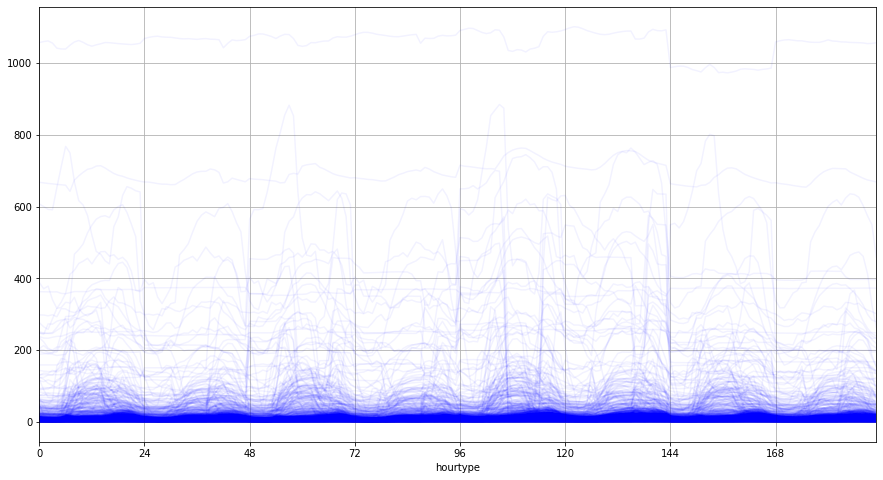

In [9]:
groups.T.plot(figsize=(15,8), legend=False, color='blue', alpha=0.05,grid=True,xlim=[0,191],xticks=range(0,192,24));

# Clustering the meters

The next task is to find the clusters that partition this dataset in loadshapes with minimal Euclidean distances to the cluster centroid.  We use the k-means algorithm to identify the cluster on the normalized hour type profiles. 

In [10]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
rescaled = MinMaxScaler().fit_transform(groups.values.copy())
kmeans = KMeans(n_clusters=10)
group_found = kmeans.fit_predict(rescaled)
group_data = pd.Series(group_found, name="loadshape")
groups.set_index(group_data, append=True, inplace=True)

A histogram of the loadshapes found shows that only a few loadshapes are common and the remaining ones are idiosyncratic.

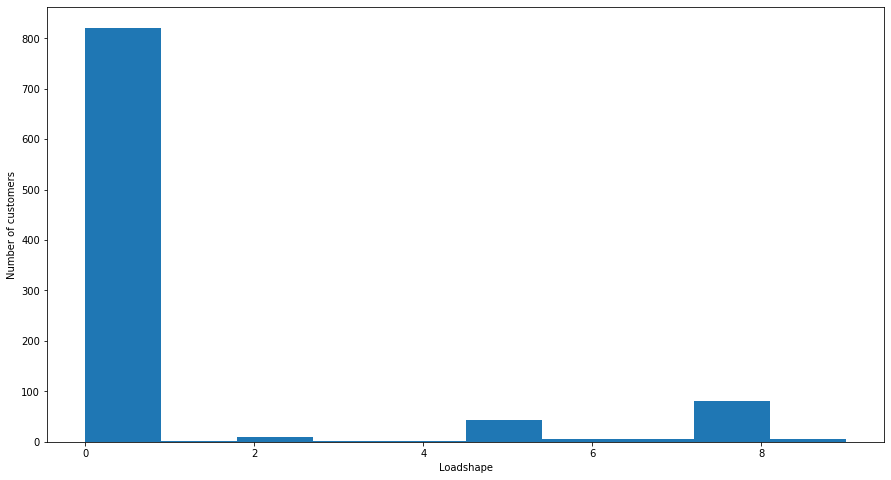

In [11]:
ax = groups.reset_index()["loadshape"].hist(figsize=(15,8),grid=False,bins=10)
ax.set_xlabel("Loadshape")
ax.set_ylabel("Number of customers");

The loadshape data is obtained by aggregating the median load and relabeling the columns to improve readability.

In [12]:
loadshapes = groups.groupby("loadshape").mean()
seasons = ["win","spr","sum","fal"]
weekdays = ["wd","we"]
loadshapes.columns = [f"{seasons[season]}_{weekdays[weekend]}_{hour}h" for season in range(4) for weekend in range(2) for hour in range(24)]

In [13]:
loadshapes

,win_wd_0h,win_wd_1h,win_wd_2h,win_wd_3h,win_wd_4h,...,fal_we_19h,fal_we_20h,fal_we_21h,fal_we_22h,fal_we_23h
loadshape,,,,,,,,,,,
0,6.889429,6.207877,5.850404,5.695278,5.813660,...,12.334530,12.130336,11.580081,10.680641,9.432366
1,607.172308,600.055385,592.181538,590.990769,653.003077,...,282.784615,273.046154,253.200000,239.838462,232.869231
2,115.281538,113.357094,111.797538,113.619368,117.079077,...,180.697265,174.771538,161.158291,139.258376,119.389915
3,1056.641538,1059.452308,1061.169231,1055.173846,1040.995385,...,1056.253846,1055.526923,1053.726923,1054.280769,1056.253846
...,...,...,...,...,...,...,...,...,...,...,...
6,299.363897,295.051769,300.648897,294.929256,295.279103,...,361.209423,352.574872,337.431410,313.632051,301.620897
7,83.088738,83.088369,82.566277,81.418708,81.482585,...,152.669538,152.616000,152.699077,151.308000,150.480923
8,22.688377,21.789962,20.959643,20.335156,20.462908,...,36.745822,34.458115,31.798029,29.199851,26.392726
9,215.425938,212.770800,205.224369,204.081600,209.036708,...,267.148615,255.344923,245.742462,234.177462,229.292308


The final results are plotted with the original data to visualize how the loadshapes are representative of each cluster.

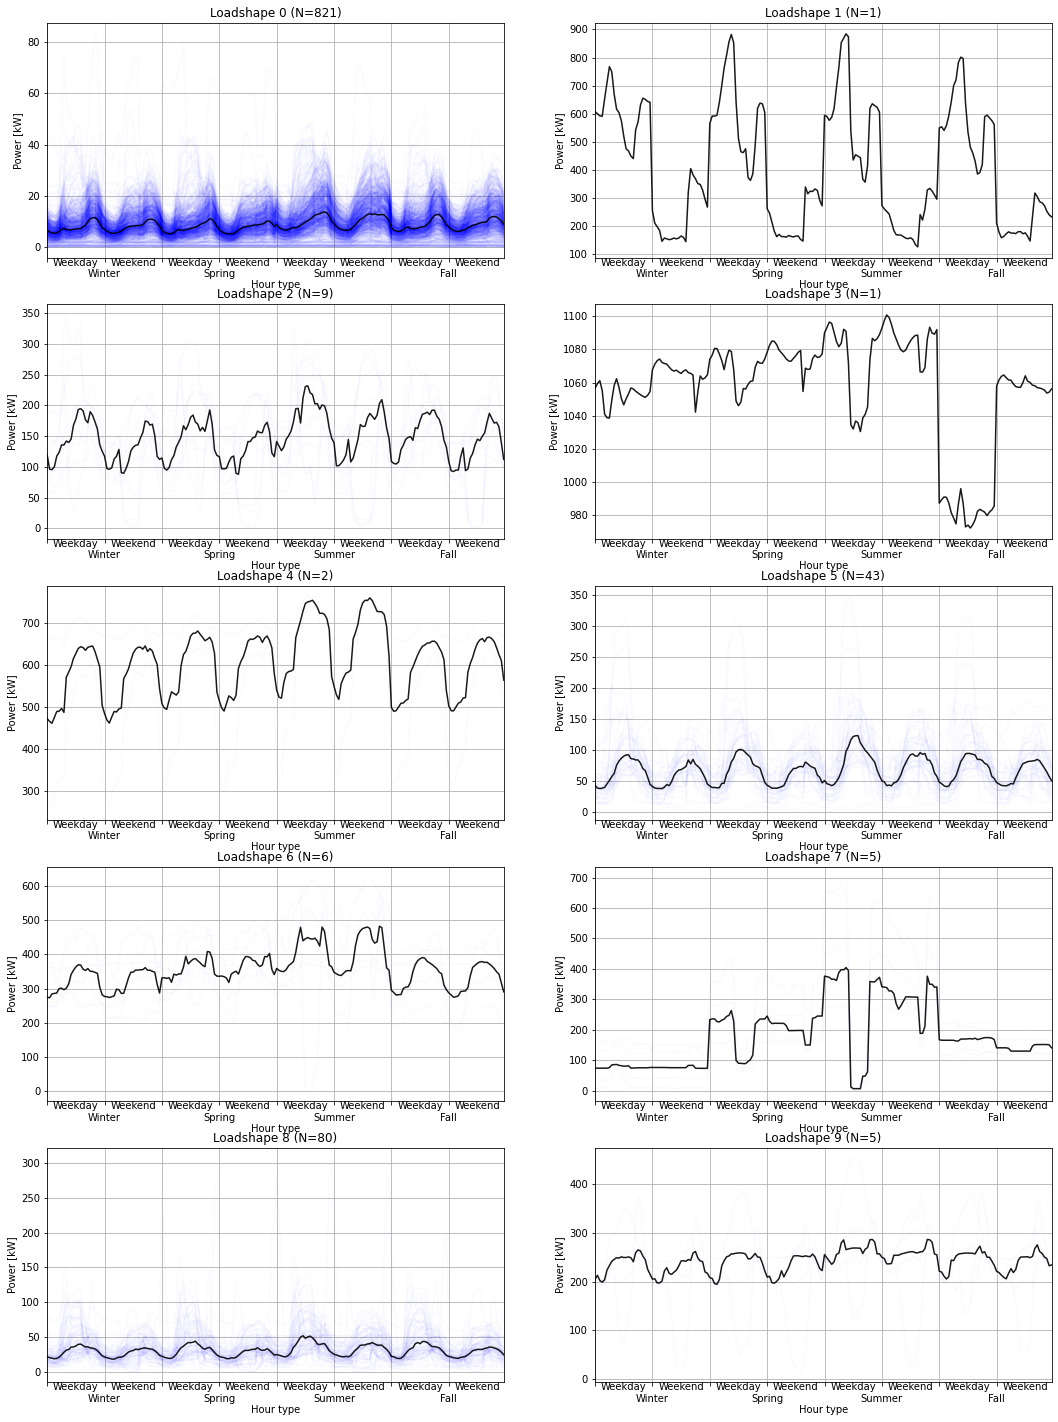

In [14]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(int(loadshapes.shape[0]/2),2, figsize=(18,2.5*loadshapes.shape[0]))
for group in groups.index.get_level_values(level=1).unique():
    subset = groups.xs(group, level=1)
    ax = plt.subplot(int(loadshapes.shape[0]/2),2,group+1)
    plt.plot(subset.T,alpha=0.02,ls='-',color="blue")
    plt.plot(subset.median(), alpha=0.9, ls='-',color="black")
    ax.set_title(f"Loadshape {group} (N={len(subset)})")
    ax.set_ylabel('Power [kW]')
    ax.set_xlabel('\nHour type')
    ax.grid()
    y0 = ax.get_ylim()[0]
    for s in range(4):
        for w in range(2):
            label = plt.text(s*48+w*24+12,y0,["Weekday","Weekend"][w],axes=ax)
            label.set_ha("center")
            label.set_va("top")
        label = plt.text(s*48+24,y0,["\nWinter","\nSpring","\nSummer","\nFall"][s],axes=ax)    
        label.set_ha("center")
        label.set_va("top")
    plt.xticks(range(0,192,24),[],axes=ax)
    plt.xlim([0,191])            

# Rescaling the loadshapes

When the identified loadshapes are used to generate a load model, the mean loadshape power (as well as the total energy) will always match the original meters' means and total energy because the methodologies uses the mean power to identify the cluster centroids.  However, the methodology does not address the different variances among the meters and these do not match the loadshapes.

To address this, compute the standard deviate for each meter power reading and its corresponding loadshape value.

In [15]:
values = groups.reset_index().set_index(["meter_id","loadshape"]).melt(ignore_index=False).reset_index().set_index(["meter_id","loadshape","hourtype"])
meters = data.drop(["tz","timestamp"],axis=1).set_index(["meter_id","hourtype"])
mapping = meters.join(values)
mapping.groupby("meter_id").std()

,power,value
meter_id,,
1,1.582521,1.127028
2,0.076137,0.071638
3,4.697922,4.305768
4,7.073779,5.767524
...,...,...
970,3.891709,3.231951
971,3.088949,2.161910
972,0.056724,0.025850
973,5.555886,3.713034


To rescale the loadshape so that each meter's loadshape has the same variance we use a linear function for each meter $m$

$$
    y_{m,t} = scale_m x[h_{t}] + offset_m
$$

where the scale $scale_m = { \sigma^2_m \over \sigma^2_l}$ with $\sigma^2_m$ being the variance of the meter data and $\sigma^2_l$ being the variance corresponding loadshape data, and $offset_m = (1-scale_m)~\mu_m$ with $\mu_m$ being the mean of the meter data.

The histograms of the scales and offsets verifies the reasonableness of the range of values found.

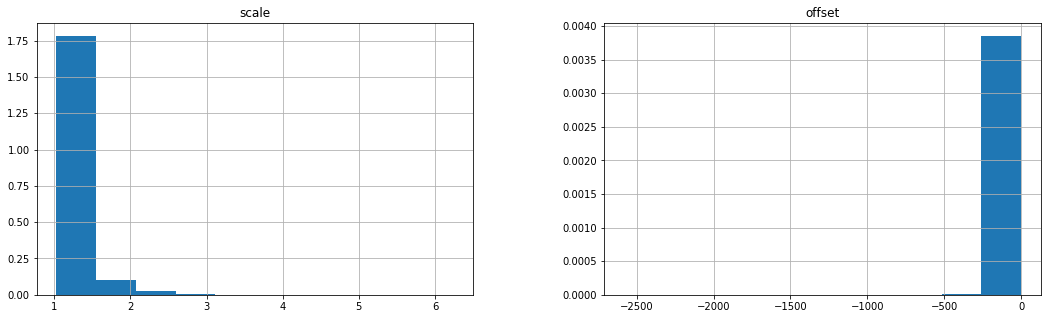

In [16]:
fig,ax = plt.subplots(1,2,figsize=(18,5))
scale = pd.DataFrame(mapping.groupby("meter_id").std().power/mapping.groupby("meter_id").std().value,columns=["scale"])
scale.hist(figsize=(10,5),density=True,ax=ax[0]);
offset = pd.DataFrame((1-scale).scale*mapping.groupby("meter_id").mean()["power"],columns=["offset"])
offset.hist(figsize=(10,5),density=True,ax=ax[1]);

The scales and offsets are now joined with the original meter data to compute the rescaled values.

In [17]:
mapping = mapping.join(scale)
mapping = mapping.join(offset)
mapping["rescaled"] = mapping.value*mapping.scale + mapping.offset
mapping

power     value     scale    offset  rescaled
meter_id hourtype loadshape                                               
1        0        0           6.31  5.737077  1.404154 -2.264103  5.791635
                  0           8.52  5.737077  1.404154 -2.264103  5.791635
                  0           6.22  5.737077  1.404154 -2.264103  5.791635
                  0           6.07  5.737077  1.404154 -2.264103  5.791635
...                            ...       ...       ...       ...       ...
973      191      0          14.57  9.771538  1.496319 -6.557975  8.063369
                  0           5.88  9.771538  1.496319 -6.557975  8.063369
                  0           7.76  9.771538  1.496319 -6.557975  8.063369
                  0           6.66  9.771538  1.496319 -6.557975  8.063369

[8904099 rows x 5 columns]

The final rescaled loadshape values have the same variance, mean power, and total energy use as the original AMI meter data:

In [18]:
final=mapping.drop(["scale","offset","value"],axis=1)
pd.DataFrame(list(map(lambda x:(x.power-x.rescaled)*(x.power-x.rescaled).max(),[final.std(),final.mean(),final.sum()])),index=["std","mean","sum"],columns=["MaxSE"]).T

,std,mean,sum
MaxSE,2.764673e-25,2.051925e-22,1.626241e-08


# Generate the loadshape  weights

The loadshape weights can be generated by computing the total energy in each loadshape meter group and dividing it by the total energy over all loadshapes.

loadshape,0,1,2,3,4,5,6,7,8,9
energy,0.302,0.038,0.06,0.082,0.067,0.133,0.1,0.037,0.122,0.058


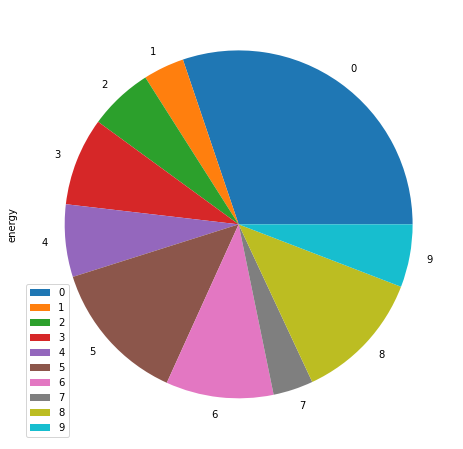

In [19]:
loadshapes = groups.drop(range(192),axis=1)
total = data.drop("tz",axis=1).set_index(["meter_id","hourtype"]).join(loadshapes).groupby("loadshape").sum()
total.columns = ["energy"]
(total/total.sum()).plot.pie(y="energy",figsize=(8,8),normalize=True);
(total/total.sum()).round(3).T

# Validation

The final result is validated using a t-distributed stochastic (t-SNE) neighbor embedding algorithim to reduce the dimensionality of the original data set to two dimensions. The color of each point in the map corresponds to each loadshape.  The grouping of similar loadshapes shows how the cluster methods produce similar results.

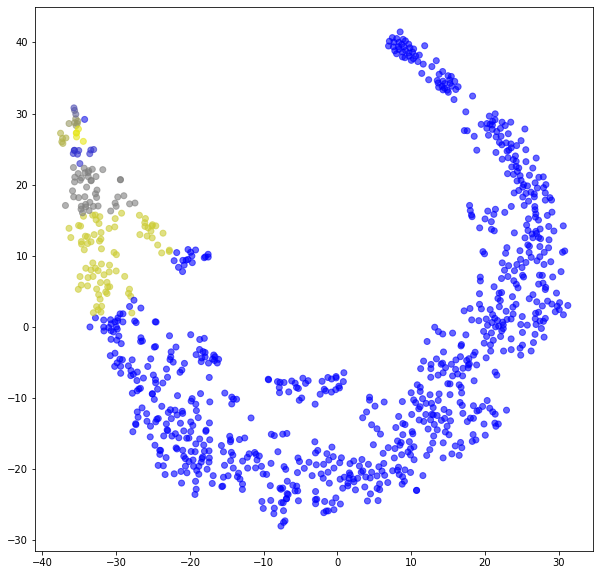

In [20]:
from sklearn.manifold import TSNE
import matplotlib.colors
import numpy as np
tsne = TSNE()
results_tsne = tsne.fit_transform(rescaled)
color_list = list(zip(np.arange(0,1,0.1),np.arange(0,1,0.1),np.arange(1,0,-0.1)))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(groups.index.get_level_values(level=1).unique(), color_list)
plt.figure(figsize=(10,10))
plt.scatter(results_tsne[:,0], results_tsne[:,1],
    c=groups.index.get_level_values(level=1),
    cmap=cmap, 
    alpha=0.6, 
    );

# Conclusions

This notebooks provides an example from which most analysts and researchers can develop their own loadshapes from AMI data. In some cases it may be necessary to do some preprocessing to the AMI data to normalize timestamps, aggregate subhourly data up to hourly day, or removed extraneous columns.  These tasks are relatively simple and straightforward, and are common enough that the reader should have no problem implementing these for themselves.

The methodology illustrated in this notebook has been implemented in both OpenFIDO (https://github.com/openfido/loadshape) and HiPAS GridLAB-D (https://www.gridlabd.us/).  